# 문제 정의

현재 공유 킥보드나 공유 자전거처럼 공유 서비스를 활용한 인도에서의 이동 수단이 늘어나는 추세다.

그러나, 이러한 공유 이동수단들은 이용 이후에 아무 곳에서나 하차를 하고 놔둘 수 있다는 문제점이 존재하고 이에 따라서 공유 이동수단이 인도가 아닌 위험지역(차도 등)에 있을 경우 이를 식별하는 시스템의 필요성에 따라 해당 시스템에 필요한 객체 탐지 모델을 설계하고자 했다.

이 때, 중요한 점은

- 빠른 속도로 거의 실시간 처리가 가능할 것

- 지속적인 학습으로 모델 업데이트가 용이할 것

- 데이터셋 크기로 인해 Incremental Learning을 구현할 수 있을 것

정도의 필요 조건을 고려하고 객체 탐지 모델을 설계한다. 

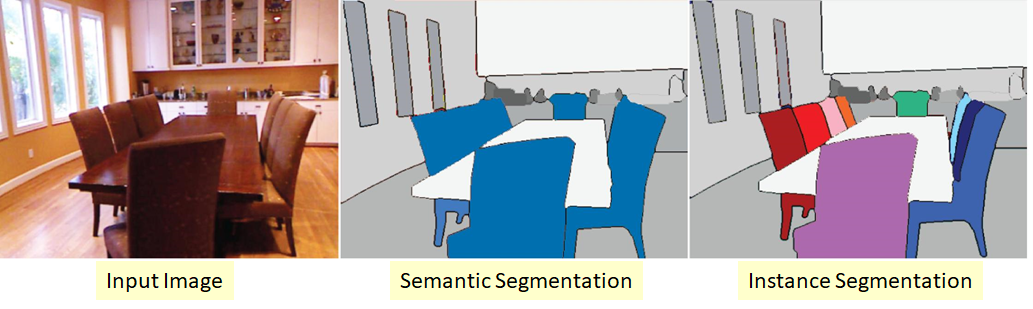

Object detection 기술 중에서 Bounding Box가 아닌 픽셀 단위의 정확도를 가진 Segmentation이 필요하고 개별 객체 분석이 필요하므로 Instance Segmentation을 사용

## 데이터셋

https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=189

### 제목 : 인도보행 영상

### 소개


인도 보행에 장애가 되는 객체 29종에 대해 박스, 폴리곤 형태로 어노테이션한 데이터 및 인도 노면 상태 정보를 폴리곤 형태로 어노테이션한 데이터를 구축한 영상 데이터 제공

### 구축목적


장애인 이동권 신장
- 인공지능의 도움으로 장애인 보행에 위협요소인 각종 장애물(자동차, 사람, 가로수, 가로등 등)과 파손 등으로 위험한 보행 노면을 피해 보다 안전하고 원활한 장애인 이동권 보장
인도보행 인공지능 분야 공개데이터 셋의 부족
- 국내 인도보행영상 데이터셋 구축 사례 전무한 상태에서 국내 환경 맞춤형 데이터셋 구축 필요 자율주행 분야에서 차도뿐 아니라 생활도로, 인도 등의 국내 다양한 도로형태에서의 데이터 셋 구축

# AI Hub에서의 데이터 전처리

AI Hub의 데이터는 굉장히 크고, 방대하며 annotation이 잘 되어 있으나 사용하고자 하는 모델에 따라서 다르게 입력값을 조정해주어야 한다.

현재 환경이 가진 RAM과 총 600GB가 넘는 데이터셋의 크기를 감안하여 데이터셋에서 필요한 부분만 추출하고 Task를 위한 적절한 선택이 필요하다고 판단한다.

해당 데이터셋은 "영상" 을 고려하고 annotation을 만들었기에 이미지에서의 Sementic Segmentaiton에서의 annotation과는 다른 부분이 존재한다.

따라서 YOLO v5에 활용 가능한 형태로 바꿔주도록 한다



TODO

- [미해결] 라벨이 데이터 내의 annotation마다 총 갯수가 다르다
> 처음에 0~n까지의 Label에 특정 사물을 배정시킨 뒤에 훈련시키고 이를 Json 형태(dictionary)로 저장한 뒤 파일을 보존한다. 이후 훈련시킬 때마다 새로운 class가 등장하면 n+1에 배정하고 Json에 저장하는 식으로 기록.

- [해결] 향후 추가될 라벨에 대해서 어떻게 처리할지 생각해봐야 함
> YOLO 라이브러리는 pretrained 모델으로 저장하는 기능이 있음. 이걸 활용하여 모델을 훈련시킨 뒤 저장하고, 다시 훈련시키는 식으로 반복하여 진행하는 것을 생각해보자

- [해결] 필요한 Label이 어떤 것인지 나누고, 해당 Label이 있는 이미지만 분류해서 학습에 사용
> 현재 고려하는 것은 인간, 킥보드, 자전거, 오토바이, 인도, 차도 정도의 Label이다.

- [해결] 데이터 특성상 밤에 찍힌 데이터가 적을 것이므로(휠체어를 탄 장애인분들이 데이터 수집에 참여) 이미지 증강을 통해 이를 고려하여 데이터를 늘려야할듯
> Brightness 조절에 대한 증강은 반드시 넣는 것으로 하자

- [미해결] 도로, 인도에 대한 추가 학습 확인

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content

/content


In [2]:
!mkdir dataset
!unzip /content/drive/MyDrive/cv/data/Polygon_2_new.zip -d /content/dataset
!unzip /content/drive/MyDrive/cv/data/Surface_1.zip -d /content/dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/dataset/Surface_091/MASK/MP_SEL_SUR_006802.png  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006753.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006754.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006755.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006756.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006757.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006758.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006759.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006760.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006761.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006762.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006763.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006764.jpg  
  inflating: /content/dataset/Surface_091/MP_SEL_SUR_006765.jpg  
  inflating: /content/dataset/Surfa

In [3]:
import os
import json
import xml.etree.ElementTree as ET
import numpy as np
import yaml
import shutil
from sklearn.model_selection import train_test_split
from collections import Counter


# label 불균형 확인하기 위한 counter
label_cv = Counter()

# xml에서 파싱하여 image_list와 label을 읽어오고 기존의 label에 부여된 숫자와 비교한 뒤, 추가될 부분은 추가합니다.
def load_xml(xml_path ,label_path="./label.json"):

  xml_anot = ET.parse(xml_path)
  root = xml_anot.getroot()

  meta = root.find('meta')

  ## image 파일들의 정보가 담긴 list
  image_list = root.findall('image')

  task = meta.find('task')

  labels = task.find('labels')

  label_list = []

  for label in labels:
    label_list.append(label[0].text)

  try:
    with open(label_path, "r") as json_file:
        label_dict = json.load(json_file)
  except:
    print("label.json 새로 생성됨")
    label_dict = {}

  label_split_list = ['person','scooter','bicycle','motorcycle', 'sidewalk', 'roadway', 'alley', 'bike_lane']
    
  for label in label_list:
    if label in label_split_list:
      if label_dict.get(label) is None:
        label_dict[label] = len(label_dict)

  ## label_dict를 저장, 이후에 로드해서 업데이트하면서 사용
  with open(label_path,'w') as f:
    json.dump(label_dict, f, indent=4)

  return image_list, label_dict


## unit_square 기준에서 normalize -> YOLO를 위한 방식은 아님
def normalize_polygon(polygon):
    polygon = np.array(polygon)

    # Translate the polygon so that its centroid is at the origin
    centroid = np.mean(polygon, axis=0)
    polygon -= centroid

    # Scale the polygon so that its bounding box fits in a unit square
    min_arr = np.array(np.min(polygon, axis=0))
    max_arr = np.array(np.max(polygon, axis=0))
    polygon = (polygon - min_arr) / (max_arr - min_arr)

    return polygon

## Input_size 기준 -> YOLO를 위한 방식
def normalize_polygon_yolov5(polygon, image_size):
    polygon = np.array(polygon)

    # Scale the polygon so that its bounding box fits in the input image
    polygon = polygon / np.array(image_size)

    return polygon


def yolo_label_txt_transform(polygons, label_dict):
  img_txt = ''

  for polygon in polygons:
      img_label = polygon.attrib['label']
      # 해당 라벨이 없을 경우 이 폴리곤은 제외한다
      if label_dict.get(img_label) is None:
        continue
      label_cv.update([img_label])
      img_polygon = polygon.attrib['points']

      point_list = img_polygon.split(';')
      polygon = [x.split(',') for x in point_list]
      polygon = [[float(point) for point in x] for x in polygon]
      
      # Normalize the polygon / input_size = 1920 1080 고정
      normalized_polygon = normalize_polygon_yolov5(polygon, [1920, 1080])

      ## label_dict와 비교해서 label을 숫자로 입력
      img_txt += str(label_dict[img_label]) + " "

      for poly in normalized_polygon:
        for point in poly:
          img_txt += str(point) + " "

      img_txt = img_txt.rstrip()
      img_txt += "\n"
  
  return img_txt[:-1]


def make_label_txt(folder, img_list, label_dict):
  # img_list 내의 모든 image에 대해서 label 값에 해당하는 폴리곤 마스킹 txt를 만든다


  # 폴더가 없으면 만드는 함수
  def make_dir(dir_name):
    dir_path = os.path.join(os.getcwd(),dir_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Folder {dir_path} created.")
    else:
        print(f"Folder {dir_path} already exists.")
    
    return dir_path
  
  # dataset 폴더가 없을 경우 생성
  make_dir("dataset")
  # labels 폴더가 없을 경우 생성
  labels_path = make_dir("./dataset/labels")
  # images 폴더가 없을 경우 생성
  images_path = make_dir("./dataset/images")

  make_dir("./dataset/labels/train")
  make_dir("./dataset/labels/val")
  make_dir("./dataset/labels/test")

  make_dir("./dataset/images/train")
  make_dir("./dataset/images/val")
  make_dir("./dataset/images/test")

  for img in img_list:
    img_name = img.attrib['name']
    img_path = os.path.join(folder, img_name)
    label_path = labels_path + "/" + img_name[:-4] + ".txt" ## 확장자 .jpg는 제거한 상태로 넣어줘야함
    polygons = img.findall('polygon')
    label_txt = yolo_label_txt_transform(polygons, label_dict)

    if label_txt == '':
      ## 이미지에 필요한 라벨이 없을 경우 삭제
      try:
        os.remove(img_path)
        print(f"{img_path} has been deleted.")
      except FileNotFoundError:
        print(f"{img_path} does not exist.")
      continue
    else:
      try:
        shutil.move(img_path, os.path.join(images_path, img_name))
        print(f"{img_path} has been moved to images dir.")
      except:
        print(f"{img_path} already moved to images dir.")
        continue

    with open(label_path, "w") as file:
        file.write(label_txt)


def preprocessing(folder):

    def xml_parsing_and_make_txt(folder):
    # Get a list of all XML files in the folder
        xml_files = [file for file in os.listdir(folder) if file.endswith('.xml')]

        for xml_file in xml_files:
            file_path = os.path.join(folder, xml_file)

        img_list, label_dict = load_xml(file_path)

        make_label_txt(folder, img_list, label_dict)
  
  # 해당 폴더 내의 모든 폴더를 탐색하고 필요없는 라벨만 있는 이미지 삭제 및 라벨 변환

    for dir in os.listdir(folder):
        sub_dir_path = os.path.join(folder, dir)
        if dir in ['images', 'labels']:
          continue
        print(sub_dir_path)
        if os.path.isdir(sub_dir_path):
    
            xml_parsing_and_make_txt(sub_dir_path)
            print(f"{sub_dir_path} 폴더 변환 완료!")
    


def make_data_yaml():
  # xml에서 파싱한 label을 기준으로 data.yaml을 설정
  # train_path와 val_path는 사용 환경에 따라 다르게 지정해줘야 함

  try:
    with open('./label.json', "r") as json_file:
        label_dict = json.load(json_file)
  except:
    print("에러 : label.json 존재하지 않음")
    return

  data = {}

  root_path = "/content/dataset/"
  train_path = "images/train/"
  val_path = "images/val/"
  test_path = "images/test/"

  new_label_dict = {}
  for k, v in label_dict.items():
      new_label_dict[v] = k

  data['names'] = new_label_dict
  data['nc'] = len(label_dict)
  data['path'] = root_path
  data['train'] = train_path
  data['val'] = val_path
  data['test'] = test_path

  with open('./data.yaml', 'w') as f:
    yaml.dump(data, f)
  print("data.yaml 생성 완료!") 


#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False


def holdout_split():
    images_path = "./dataset/images"
    labels_path = "./dataset/labels"

    # Read images and annotations
    images = [x[:-4] for x in os.listdir(images_path) if x[-3:] == "jpg"]
    annotations = [x[:-4] for x in os.listdir(labels_path) if x[-3:] == "txt"]

    images.sort()
    annotations.sort()
    
    solo_list = []

    for a in annotations:
      if a not in images:
        solo_list.append(a)

    for a in solo_list:
      annotations.remove(a)

    images = [os.path.join(images_path, x + ".jpg") for x in images]
    annotations = [os.path.join(labels_path, x + ".txt") for x in annotations]


    # Split the dataset into train-valid-test splits 
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 42)
    val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 42)

    # Move the splits into their folders
    move_files_to_folder(train_images, './dataset/images/train')
    move_files_to_folder(val_images, './dataset/images/val/')
    move_files_to_folder(test_images, './dataset/images/test/')
    move_files_to_folder(train_annotations, './dataset/labels/train/')
    move_files_to_folder(val_annotations, './dataset/labels/val/')
    move_files_to_folder(test_annotations, './dataset/labels/test/')

    print("hold-out 완료")

    dir_path = "./dataset"

    for sub in os.listdir(dir_path):
      if sub not in ['images', 'labels']:
        shutil.rmtree(os.path.join(dir_path, sub))
    print("기존에 있던 images,labels를 제외한 폴더 삭제 완료")

    

In [4]:
folder = "dataset"
preprocessing(folder)
make_data_yaml()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
dataset/Surface_111/MP_SEL_SUR_008682.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008683.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008684.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008685.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008686.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008687.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008688.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008689.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008690.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008691.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008692.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008693.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_SUR_008694.jpg has been moved to images dir.
dataset/Surface_111/MP_SEL_S

In [5]:
holdout_split()

hold-out 완료
기존에 있던 images,labels를 제외한 폴더 삭제 완료


In [7]:
label_cv.most_common(10)

[('sidewalk', 13115),
 ('roadway', 7862),
 ('alley', 6127),
 ('person', 5581),
 ('motorcycle', 1682),
 ('bicycle', 1330),
 ('bike_lane', 895),
 ('scooter', 121)]

Instance에서 불균형이 나타나는데, 적을수록 정확도가 떨어지는 것이 확인된다.

In [ ]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

print(get_dir_size('./dataset'))

3661813041


총 용량은 3661813041바이트로, 대략 3661 MB 정도다. 압축된 파일이 10GB 정도이며 압축 해제시 20GB가 넘는 것을 생각하면 전처리로 필요한 파일만 골라낸 덕분에 메모리와 RAM을 아낄 수 있었다.

### 이미지 마스킹 시각화

<ipython-input-67-105302338035>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return image, polygon.astype(np.int)


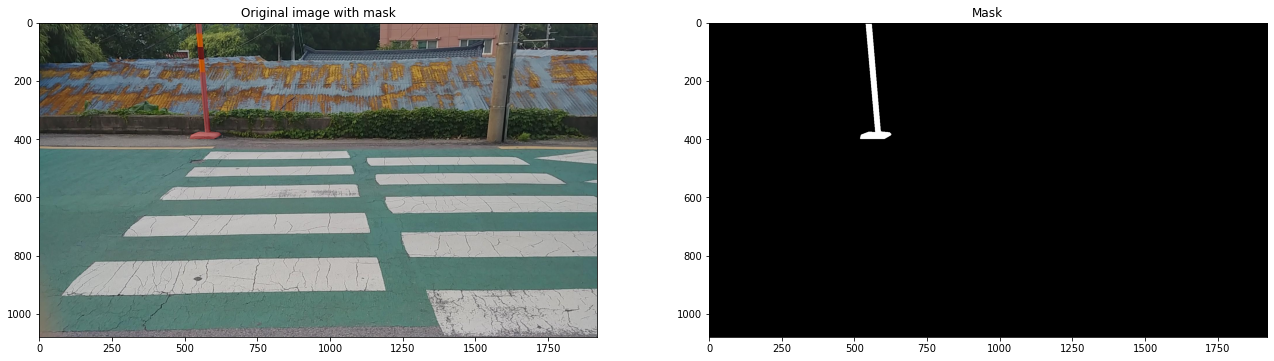

In [ ]:
import cv2
import matplotlib.pyplot as plt
from typing import Tuple

def read_image_label(path_to_img: str, path_to_txt: str, normilize: bool = False) -> Tuple[np.array, np.array]:
    
    # read image
    image = cv2.imread(path_to_img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w = image.shape[:2]
  
    # read .txt file for this image
    with open(path_to_txt, "r") as f:
        txt_file = f.readlines()[0].split()
        cls_idx = txt_file[0]
        coords = txt_file[1:]
        polygon = np.array([[eval(x), eval(y)] for x, y in zip(coords[0::2], coords[1::2])]) # convert list of coordinates to numpy massive
  
    # Convert normilized coordinates of polygons to coordinates of image
    if normilize:
        polygon[:,0] = polygon[:,0]*img_w
        polygon[:,1] = polygon[:,1]*img_h
    return image, polygon.astype(np.int)

image, polygon = read_image_label("/content/MP_SEL_P000002.jpg", "/content/MP_SEL_P000002.jpg.txt", True)

def show_image_mask(img: np.array, polygon: np.array, alpha: float = 0.7):
    
    # Create zero array for mask
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    overlay = img.copy()
    
    # Draw polygon on the image and mask
    cv2.fillPoly(mask, pts=[polygon], color=(255, 255, 255))
    cv2.fillPoly(img, pts=[polygon], color=(255, 0, 0))
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    
    # Plot image with mask
    fig = plt.figure(figsize=(22,18))
    axes = fig.subplots(nrows=1, ncols=2)
    axes[0].imshow(img)
    axes[1].imshow(mask, cmap="Greys_r")
    axes[0].set_title("Original image with mask")
    axes[1].set_title("Mask")
    
    plt.show()

show_image_mask(image, polygon)

txt 파일을 불러왔을 때의 마스킹을 시각화한 것으로

기존 xml에서 txt 파일으로 변환이 제대로 된 것을 확인할 수 있다.



# YOLO v5 모델 학습

In [6]:
%cd /content/drive/MyDrive/cv

/content/drive/MyDrive/cv


In [7]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-74-gd02ee60 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 57.9/166.8 GB disk)


여전히 에러. data.yaml에서 클래스 name 부분을 딕셔너리 형태로 넣어줘야 했다.

그래도 에러. data.yaml에서 path를 추가

segment를 위한 train.py가 따로 있었다.

이걸 지정안해준게 문제였다 -> 여전히 에러

결국 찾았다. txt 파일의 이름은 jpg 확장자는 빼야한다. 그냥 이름까지만 적어주면 된다. [해결]



In [ ]:
!python3 segment/train.py --data ../data.yaml --weights yolov5s-seg.pt --img 1920 --batch-size 2 --epochs 5

segment/train: weights=yolov5s-seg.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=2, imgsz=1920, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train-seg, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, mask_ratio=4, no_overlap=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-74-gd02ee60 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, s

GPU 사용 안할경우 23시간 가량 걸린다.

무조건 사용해야 할듯 하다

GPU 사용시 batch_size 2 epoch 5 에서 1시간 23분이 걸렸다

image 내의 객체 각각을 Instances라고 하는데, 이에 대한 불균형한 데이터로 인해서 학습에 문제가 발생할 수 있다는 것을 확인했다.

## Incremental learning

현재 환경의 한계로 인해 데이터셋을 전부 저장하기가 힘들다. 따라서, 데이터셋을 나눠서 학습시키기로 한다

best.pt 에 저장된 가중치를 계속해서 이어받아서 새로운 클래스와 데이터셋을 토대로 학습한다

In [8]:
!python3 segment/train.py --data /content/data.yaml --weights /content/drive/MyDrive/cv/yolov5/runs/train-seg/exp/weights/best.pt --img 1920 --batch-size 4 --epochs 15 --hyp hyp.VOC.yaml

segment/train: weights=/content/drive/MyDrive/cv/yolov5/runs/train-seg/exp/weights/best.pt, cfg=, data=/content/data.yaml, hyp=hyp.VOC.yaml, epochs=15, batch_size=4, imgsz=1920, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train-seg, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, mask_ratio=4, no_overlap=False
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 4.17 KiB | 106.00 KiB/s, done.
Command 'git fetch origin' timed out after 5 seconds
From https://github.com/ultralytics/yolov5
   b8a2c47..b1a3126  master               -> origin

데이터셋을 나눠서 학습하고, 데이터셋을 변환하는 과정이 있기 때문에 class를 제대로 기록해놓고 저장해서 모든 학습 과정에서 동일한 Label이 동일한 정수를 부여받도록 해야한다

In [9]:
%cp /content/yolov5/runs/train-seg/exp/weights/best.pt /content/drive/MyDrive/cv

In [22]:
!python detect.py --weights /content/drive/MyDrive/cv/yolov5/runs/train-seg/exp8/weights/best.pt --img 1920 --data /content/data.yaml --conf 0.3 --source /content/test

detect: weights=['/content/drive/MyDrive/cv/yolov5/runs/train-seg/exp8/weights/best.pt'], source=/content/test, data=/content/data.yaml, imgsz=[1920, 1920], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-74-gd02ee60 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 165 layers, 7417301 parameters, 0 gradients, 25.7 GFLOPs
image 1/1 /content/test/MP_TW_P001850.jpg: 1088x1920 (no detections), 55.2ms
Speed: 2.0ms pre-process, 55.2ms inference, 0.5ms NMS per image at shape (1, 3, 1920, 1920)
Results saved to runs/detect/exp
